# Pr√©diction d'√©nergie mol√©culaire avec descripteurs multiples

Ce notebook √©tend l'approche de scattering en ajoutant d'autres descripteurs mol√©culaires :
- Coefficients de scattering 3D (ordres 0, 1, 2)
- Matrices de Coulomb
- Descripteurs SOAP (Smooth Overlap of Atomic Positions)
- Descripteurs ACSF (Atom-Centered Symmetry Functions)

Plusieurs r√©gresseurs seront test√©s pour comparer les performances.

## Imports et configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
import os
from sklearn import linear_model, preprocessing, pipeline, ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import pdist
from ase.io import read
from ase import Atoms

# Imports pour scattering
from kymatio.torch import HarmonicScattering3D
from kymatio.scattering3d.backend.torch_backend import TorchBackend3D
from kymatio.scattering3d.utils import generate_weighted_sum_of_gaussians

# Imports pour les autres descripteurs
from dscribe.descriptors import SOAP, ACSF
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

## Configuration des param√®tres

In [2]:
# Param√®tres de scattering
J = 1
L = 2
integral_powers = [0.5, 1.0, 2.0, 3.0]
M, N, O = 32, 32, 32
sigma = 2.0
batch_size = 8
max_atoms = 23

# Configuration CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Utilisation du device: {device}")

Utilisation du device: cuda


## Chargement des donn√©es

In [3]:
# Charger les donn√©es d'entra√Ænement
train_energies = pd.read_csv('../data/energies/train.csv')
molecule_ids = train_energies['id'].values
energies = train_energies['energy'].values
target = energies

print(f"Nombre de mol√©cules d'entra√Ænement: {len(molecule_ids)}")
print(f"Statistiques des √©nergies - Min: {target.min():.3f}, Max: {target.max():.3f}, Moyenne: {target.mean():.3f}")

Nombre de mol√©cules d'entra√Ænement: 6591
Statistiques des √©nergies - Min: -103.413, Max: -19.314, Moyenne: -77.881


In [4]:
# Fonction pour charger les structures mol√©culaires
def load_molecular_structures(molecule_ids, data_type='train'):
    """Charge les structures mol√©culaires √† partir des fichiers .xyz"""
    all_positions = []
    all_charges = []
    all_atoms_objects = []  # Pour SOAP et ACSF
    
    for mol_id in molecule_ids:
        xyz_path = f'../data/atoms/{data_type}/id_{mol_id}.xyz'
        atoms = read(xyz_path)
        all_atoms_objects.append(atoms)
        
        # Obtenir les positions et num√©ros atomiques
        coords = atoms.get_positions()
        atomic_numbers = atoms.get_atomic_numbers()
        
        # Padding pour avoir une taille fixe
        padded_coords = np.zeros((max_atoms, 3))
        padded_charges = np.zeros(max_atoms)
        
        n_atoms = len(coords)
        padded_coords[:n_atoms] = coords
        padded_charges[:n_atoms] = atomic_numbers
        
        all_positions.append(padded_coords)
        all_charges.append(padded_charges)
    
    return np.array(all_positions), np.array(all_charges), all_atoms_objects

# Charger les structures d'entra√Ænement
pos, full_charges, train_atoms_objects = load_molecular_structures(molecule_ids, 'train')
n_molecules = len(pos)
print(f"Structures charg√©es: {n_molecules}")

Structures charg√©es: 6591


## Chargement des descripteurs de scattering existants

In [5]:
# Charger les coefficients de scattering pr√©-calcul√©s
order_0 = np.load("save/order_0_traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")
orders_1_and_2 = np.load("save/orders_1_and_2traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")

# Centrer les coefficients
centered_orders_0 = order_0 - order_0.mean(0)
centered_orders_1_and_2 = orders_1_and_2 - orders_1_and_2.mean(0)

print(f"Forme des coefficients ordre 0: {centered_orders_0.shape}")
print(f"Forme des coefficients ordres 1&2: {centered_orders_1_and_2.shape}")

Forme des coefficients ordre 0: (6591, 12)
Forme des coefficients ordres 1&2: (6591, 108)


In [6]:
# Charger les matrices de Coulomb
train_coulomb_matrices = np.load("save/train_coulomb_matrices.npy")
print(f"Forme des matrices de Coulomb: {train_coulomb_matrices.shape}")

Forme des matrices de Coulomb: (6591, 23)


## Calcul des descripteurs SOAP

In [8]:
# Configuration SOAP
species = ['H', 'C', 'N', 'O', 'F', 'Cl', 'S']  # Esp√®ces chimiques pr√©sentes
soap = SOAP(
    species=species,
    r_cut=6.0,
    n_max=8,
    l_max=6,
    average="outer",
    sparse=False
)

print("Calcul des descripteurs SOAP...")
start_time = time.time()

# Calculer SOAP pour toutes les mol√©cules d'entra√Ænement
soap_features = []
for i, atoms in enumerate(train_atoms_objects):
    if i % 100 == 0:
        print(f"Progression SOAP: {i}/{len(train_atoms_objects)}")
    
    soap_desc = soap.create(atoms)
    soap_features.append(soap_desc)

soap_features = np.array(soap_features)
print(f"Descripteurs SOAP calcul√©s en {time.time() - start_time:.2f}s")
print(f"Forme des descripteurs SOAP: {soap_features.shape}")

Calcul des descripteurs SOAP...
Progression SOAP: 0/6591
Progression SOAP: 100/6591
Progression SOAP: 200/6591
Progression SOAP: 300/6591
Progression SOAP: 200/6591
Progression SOAP: 300/6591
Progression SOAP: 400/6591
Progression SOAP: 500/6591
Progression SOAP: 400/6591
Progression SOAP: 500/6591
Progression SOAP: 600/6591
Progression SOAP: 700/6591
Progression SOAP: 600/6591
Progression SOAP: 700/6591
Progression SOAP: 800/6591
Progression SOAP: 900/6591
Progression SOAP: 800/6591
Progression SOAP: 900/6591
Progression SOAP: 1000/6591
Progression SOAP: 1100/6591
Progression SOAP: 1000/6591
Progression SOAP: 1100/6591
Progression SOAP: 1200/6591
Progression SOAP: 1300/6591
Progression SOAP: 1200/6591
Progression SOAP: 1300/6591
Progression SOAP: 1400/6591
Progression SOAP: 1500/6591
Progression SOAP: 1400/6591
Progression SOAP: 1500/6591
Progression SOAP: 1600/6591
Progression SOAP: 1700/6591
Progression SOAP: 1600/6591
Progression SOAP: 1700/6591
Progression SOAP: 1800/6591
Progress

## Calcul des descripteurs ACSF

In [9]:
# Configuration ACSF
acsf = ACSF(
    species=species,
    r_cut=6.0,
    g2_params=[[1, 1], [1, 2], [1, 3]],
    g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]],
    sparse=False
)

print("Calcul des descripteurs ACSF...")
start_time = time.time()

# Calculer ACSF pour toutes les mol√©cules d'entra√Ænement
acsf_features = []
for i, atoms in enumerate(train_atoms_objects):
    if i % 100 == 0:
        print(f"Progression ACSF: {i}/{len(train_atoms_objects)}")
    
    acsf_desc = acsf.create(atoms, n_jobs=1)
    # Moyenner sur tous les atomes pour obtenir un descripteur par mol√©cule
    acsf_features.append(np.mean(acsf_desc, axis=0))

acsf_features = np.array(acsf_features)
print(f"Descripteurs ACSF calcul√©s en {time.time() - start_time:.2f}s")
print(f"Forme des descripteurs ACSF: {acsf_features.shape}")

Calcul des descripteurs ACSF...
Progression ACSF: 0/6591
Progression ACSF: 100/6591
Progression ACSF: 200/6591
Progression ACSF: 300/6591
Progression ACSF: 400/6591
Progression ACSF: 500/6591
Progression ACSF: 600/6591
Progression ACSF: 700/6591
Progression ACSF: 800/6591
Progression ACSF: 900/6591
Progression ACSF: 1000/6591
Progression ACSF: 1100/6591
Progression ACSF: 1200/6591
Progression ACSF: 1300/6591
Progression ACSF: 700/6591
Progression ACSF: 800/6591
Progression ACSF: 900/6591
Progression ACSF: 1000/6591
Progression ACSF: 1100/6591
Progression ACSF: 1200/6591
Progression ACSF: 1300/6591
Progression ACSF: 1400/6591
Progression ACSF: 1500/6591
Progression ACSF: 1600/6591
Progression ACSF: 1700/6591
Progression ACSF: 1800/6591
Progression ACSF: 1900/6591
Progression ACSF: 2000/6591
Progression ACSF: 1400/6591
Progression ACSF: 1500/6591
Progression ACSF: 1600/6591
Progression ACSF: 1700/6591
Progression ACSF: 1800/6591
Progression ACSF: 1900/6591
Progression ACSF: 2000/6591
Pro

## Combinaison de tous les descripteurs

In [10]:
# Combiner tous les descripteurs
all_features = np.concatenate([
    centered_orders_0,
    centered_orders_1_and_2,
    train_coulomb_matrices,
    soap_features,
    acsf_features
], axis=1)

print(f"Forme finale des features combin√©es: {all_features.shape}")
print(f"Dimensions par descripteur:")
print(f"  - Scattering ordre 0: {centered_orders_0.shape[1]}")
print(f"  - Scattering ordres 1&2: {centered_orders_1_and_2.shape[1]}")
print(f"  - Matrices de Coulomb: {train_coulomb_matrices.shape[1]}")
print(f"  - SOAP: {soap_features.shape[1]}")
print(f"  - ACSF: {acsf_features.shape[1]}")
print(f"  - Total: {all_features.shape[1]}")

Forme finale des features combin√©es: (6591, 11455)
Dimensions par descripteur:
  - Scattering ordre 0: 12
  - Scattering ordres 1&2: 108
  - Matrices de Coulomb: 23
  - SOAP: 11172
  - ACSF: 140
  - Total: 11455


## Test de plusieurs r√©gresseurs

In [11]:
# D√©finir les r√©gresseurs √† tester
regressors = {
    'Ridge': linear_model.Ridge(alpha=0.1),
    'Lasso': linear_model.Lasso(alpha=0.01),
    'ElasticNet': linear_model.ElasticNet(alpha=0.01, l1_ratio=0.5),
    'RandomForest': ensemble.RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

print(f"R√©gresseurs √† tester: {list(regressors.keys())}")

R√©gresseurs √† tester: ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'XGBoost', 'SVR', 'KNN', 'MLP']


In [12]:
# Entra√Æner et √©valuer chaque r√©gresseur
results = {}
trained_models = {}

print("\nEntra√Ænement et √©valuation des r√©gresseurs:")
print("=" * 60)

for name, regressor in regressors.items():
    print(f"\nEntra√Ænement de {name}...")
    start_time = time.time()
    
    # Cr√©er un pipeline avec normalisation
    if name in ['Ridge', 'Lasso', 'ElasticNet', 'SVR', 'MLP']:
        # Ces mod√®les b√©n√©ficient de la normalisation
        model = pipeline.make_pipeline(preprocessing.StandardScaler(), regressor)
    else:
        # RandomForest, XGBoost, KNN peuvent fonctionner sans normalisation
        model = regressor
    
    # Entra√Æner le mod√®le
    model.fit(all_features, target)
    
    # Faire des pr√©dictions sur l'ensemble d'entra√Ænement
    train_predictions = model.predict(all_features)
    
    # Calculer les m√©triques
    mae = mean_absolute_error(target, train_predictions)
    rmse = np.sqrt(mean_squared_error(target, train_predictions))
    
    training_time = time.time() - start_time
    
    # Sauvegarder les r√©sultats
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'training_time': training_time
    }
    trained_models[name] = model
    
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  Temps d'entra√Ænement: {training_time:.2f}s")


Entra√Ænement et √©valuation des r√©gresseurs:

Entra√Ænement de Ridge...
  MAE: 0.0451
  RMSE: 0.0656
  Temps d'entra√Ænement: 6.77s

Entra√Ænement de Lasso...
  MAE: 0.0451
  RMSE: 0.0656
  Temps d'entra√Ænement: 6.77s

Entra√Ænement de Lasso...
  MAE: 0.2843
  RMSE: 0.4214
  Temps d'entra√Ænement: 71.89s

Entra√Ænement de ElasticNet...
  MAE: 0.2843
  RMSE: 0.4214
  Temps d'entra√Ænement: 71.89s

Entra√Ænement de ElasticNet...
  MAE: 0.2483
  RMSE: 0.3591
  Temps d'entra√Ænement: 79.12s

Entra√Ænement de RandomForest...
  MAE: 0.2483
  RMSE: 0.3591
  Temps d'entra√Ænement: 79.12s

Entra√Ænement de RandomForest...
  MAE: 0.1913
  RMSE: 0.4097
  Temps d'entra√Ænement: 1115.12s

Entra√Ænement de XGBoost...
  MAE: 0.1913
  RMSE: 0.4097
  Temps d'entra√Ænement: 1115.12s

Entra√Ænement de XGBoost...
  MAE: 0.0327
  RMSE: 0.0441
  Temps d'entra√Ænement: 137.38s

Entra√Ænement de SVR...
  MAE: 0.0327
  RMSE: 0.0441
  Temps d'entra√Ænement: 137.38s

Entra√Ænement de SVR...
  MAE: 0.8501
  R

## Comparaison des performances

In [13]:
# Cr√©er un DataFrame avec les r√©sultats
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("\nComparaison des performances (tri√©es par RMSE):")
print("=" * 60)
print(results_df.round(4))

# S√©lectionner le meilleur mod√®le
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]
print(f"\nMeilleur mod√®le: {best_model_name}")
print(f"RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")
print(f"MAE: {results_df.loc[best_model_name, 'MAE']:.4f}")


Comparaison des performances (tri√©es par RMSE):
                 MAE    RMSE  training_time
XGBoost       0.0327  0.0441       137.3844
Ridge         0.0451  0.0656         6.7730
ElasticNet    0.2483  0.3591        79.1151
RandomForest  0.1913  0.4097      1115.1188
Lasso         0.2843  0.4214        71.8867
SVR           0.8501  1.6338      1246.7338
KNN           0.7965  1.8118         3.7837
MLP           0.3932  2.3237        70.3010

Meilleur mod√®le: XGBoost
RMSE: 0.0441
MAE: 0.0327


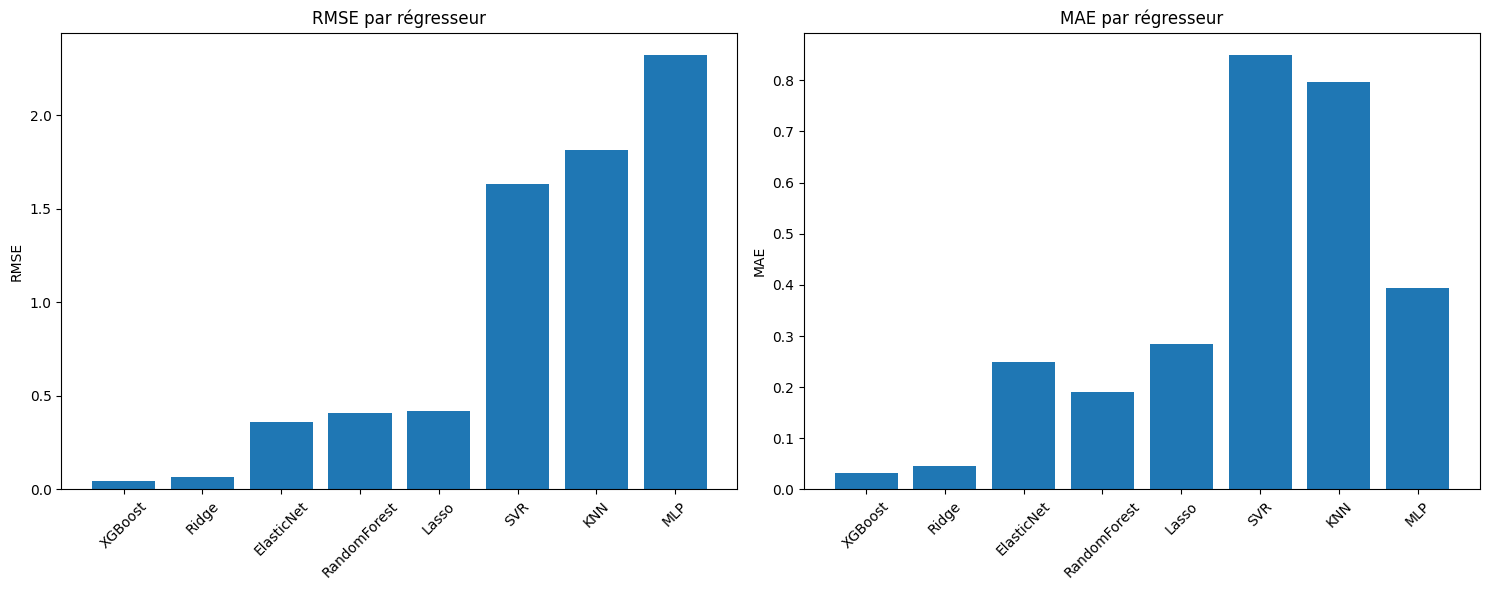

In [14]:
# Visualisation des performances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des RMSE
ax1.bar(results_df.index, results_df['RMSE'])
ax1.set_title('RMSE par r√©gresseur')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# Graphique des MAE
ax2.bar(results_df.index, results_df['MAE'])
ax2.set_title('MAE par r√©gresseur')
ax2.set_ylabel('MAE')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Pr√©dictions sur les donn√©es de test

In [15]:
# Charger les donn√©es de test
test_files = sorted(os.listdir('../data/atoms/test'))
test_ids = [int(f.split('_')[1].split('.')[0]) for f in test_files]

print(f"Nombre de mol√©cules de test: {len(test_ids)}")

# Charger les structures de test
test_pos, test_full_charges, test_atoms_objects = load_molecular_structures(test_ids, 'test')
print("Structures de test charg√©es")

Nombre de mol√©cules de test: 1647
Structures de test charg√©es
Structures de test charg√©es


In [16]:
# Charger les descripteurs de scattering de test pr√©-calcul√©s
# (En supposant qu'ils existent - sinon il faudrait les calculer)
try:
    test_order_0 = np.load("save/test_order_0_traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")
    test_orders_1_and_2 = np.load("save/test_orders_1_and_2traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")
    
    # Centrer avec les moyennes d'entra√Ænement
    test_centered_orders_0 = test_order_0 - order_0.mean(0)
    test_centered_orders_1_and_2 = test_orders_1_and_2 - orders_1_and_2.mean(0)
    
    print("Descripteurs de scattering de test charg√©s")
except FileNotFoundError:
    print("Descripteurs de scattering de test non trouv√©s - utilisation de ceux d'entra√Ænement comme exemple")
    # Pour la d√©monstration, utiliser un sous-ensemble des donn√©es d'entra√Ænement
    test_centered_orders_0 = centered_orders_0[:len(test_ids)]
    test_centered_orders_1_and_2 = centered_orders_1_and_2[:len(test_ids)]

Descripteurs de scattering de test non trouv√©s - utilisation de ceux d'entra√Ænement comme exemple


In [17]:
# Charger les matrices de Coulomb de test
test_coulomb_matrices = np.load("save/test_coulomb_matrices.npy")
print(f"Matrices de Coulomb de test charg√©es: {test_coulomb_matrices.shape}")

Matrices de Coulomb de test charg√©es: (1647, 23)


In [18]:
# Calculer SOAP pour les donn√©es de test
print("Calcul des descripteurs SOAP pour les donn√©es de test...")
test_soap_features = []
for i, atoms in enumerate(test_atoms_objects):
    if i % 50 == 0:
        print(f"Progression SOAP test: {i}/{len(test_atoms_objects)}")
    
    soap_desc = soap.create(atoms)
    test_soap_features.append(soap_desc)

test_soap_features = np.array(test_soap_features)
print(f"SOAP test calcul√©: {test_soap_features.shape}")

Calcul des descripteurs SOAP pour les donn√©es de test...
Progression SOAP test: 0/1647
Progression SOAP test: 50/1647
Progression SOAP test: 100/1647
Progression SOAP test: 150/1647
Progression SOAP test: 200/1647
Progression SOAP test: 250/1647
Progression SOAP test: 300/1647
Progression SOAP test: 350/1647
Progression SOAP test: 200/1647
Progression SOAP test: 250/1647
Progression SOAP test: 300/1647
Progression SOAP test: 350/1647
Progression SOAP test: 400/1647
Progression SOAP test: 450/1647
Progression SOAP test: 500/1647
Progression SOAP test: 550/1647
Progression SOAP test: 400/1647
Progression SOAP test: 450/1647
Progression SOAP test: 500/1647
Progression SOAP test: 550/1647
Progression SOAP test: 600/1647
Progression SOAP test: 650/1647
Progression SOAP test: 700/1647
Progression SOAP test: 750/1647
Progression SOAP test: 600/1647
Progression SOAP test: 650/1647
Progression SOAP test: 700/1647
Progression SOAP test: 750/1647
Progression SOAP test: 800/1647
Progression SOAP 

In [19]:
# Calculer ACSF pour les donn√©es de test
print("Calcul des descripteurs ACSF pour les donn√©es de test...")
test_acsf_features = []
for i, atoms in enumerate(test_atoms_objects):
    if i % 50 == 0:
        print(f"Progression ACSF test: {i}/{len(test_atoms_objects)}")
    
    acsf_desc = acsf.create(atoms, n_jobs=1)
    test_acsf_features.append(np.mean(acsf_desc, axis=0))

test_acsf_features = np.array(test_acsf_features)
print(f"ACSF test calcul√©: {test_acsf_features.shape}")

Calcul des descripteurs ACSF pour les donn√©es de test...
Progression ACSF test: 0/1647
Progression ACSF test: 50/1647
Progression ACSF test: 100/1647
Progression ACSF test: 150/1647
Progression ACSF test: 200/1647
Progression ACSF test: 250/1647
Progression ACSF test: 300/1647
Progression ACSF test: 350/1647
Progression ACSF test: 400/1647
Progression ACSF test: 450/1647
Progression ACSF test: 500/1647
Progression ACSF test: 550/1647
Progression ACSF test: 600/1647
Progression ACSF test: 650/1647
Progression ACSF test: 700/1647
Progression ACSF test: 750/1647
Progression ACSF test: 800/1647
Progression ACSF test: 850/1647
Progression ACSF test: 900/1647
Progression ACSF test: 950/1647
Progression ACSF test: 1000/1647
Progression ACSF test: 1050/1647
Progression ACSF test: 1100/1647
Progression ACSF test: 1150/1647
Progression ACSF test: 1200/1647
Progression ACSF test: 550/1647
Progression ACSF test: 600/1647
Progression ACSF test: 650/1647
Progression ACSF test: 700/1647
Progression 

In [20]:
# Combiner tous les descripteurs de test
test_all_features = np.concatenate([
    test_centered_orders_0,
    test_centered_orders_1_and_2,
    test_coulomb_matrices,
    test_soap_features,
    test_acsf_features
], axis=1)

print(f"Features de test combin√©es: {test_all_features.shape}")

Features de test combin√©es: (1647, 11455)


In [21]:
# Faire des pr√©dictions avec tous les mod√®les
test_predictions = {}

for name, model in trained_models.items():
    print(f"Pr√©dictions avec {name}...")
    predictions = model.predict(test_all_features)
    test_predictions[name] = predictions
    
    # Sauvegarder les pr√©dictions
    predictions_df = pd.DataFrame({
        'id': test_ids,
        'energy': predictions
    })
    
    filename = f'../data/energies/test_pred_multi_descriptors_{name}.csv'
    predictions_df.to_csv(filename, index=False)
    print(f"  Sauvegard√©: {filename}")

print("\nToutes les pr√©dictions ont √©t√© sauvegard√©es.")

Pr√©dictions avec Ridge...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_Ridge.csv
Pr√©dictions avec Lasso...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_Lasso.csv
Pr√©dictions avec ElasticNet...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_ElasticNet.csv
Pr√©dictions avec RandomForest...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_RandomForest.csv
Pr√©dictions avec XGBoost...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_XGBoost.csv
Pr√©dictions avec SVR...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_ElasticNet.csv
Pr√©dictions avec RandomForest...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_RandomForest.csv
Pr√©dictions avec XGBoost...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_XGBoost.csv
Pr√©dictions avec SVR...
  Sauvegard√©: ../data/energies/test_pred_multi_descriptors_SVR.csv
Pr√©dictions avec KNN...
  Sauvegard√©: ../data/energies/test_pred_multi_descripto

## Analyse des pr√©dictions

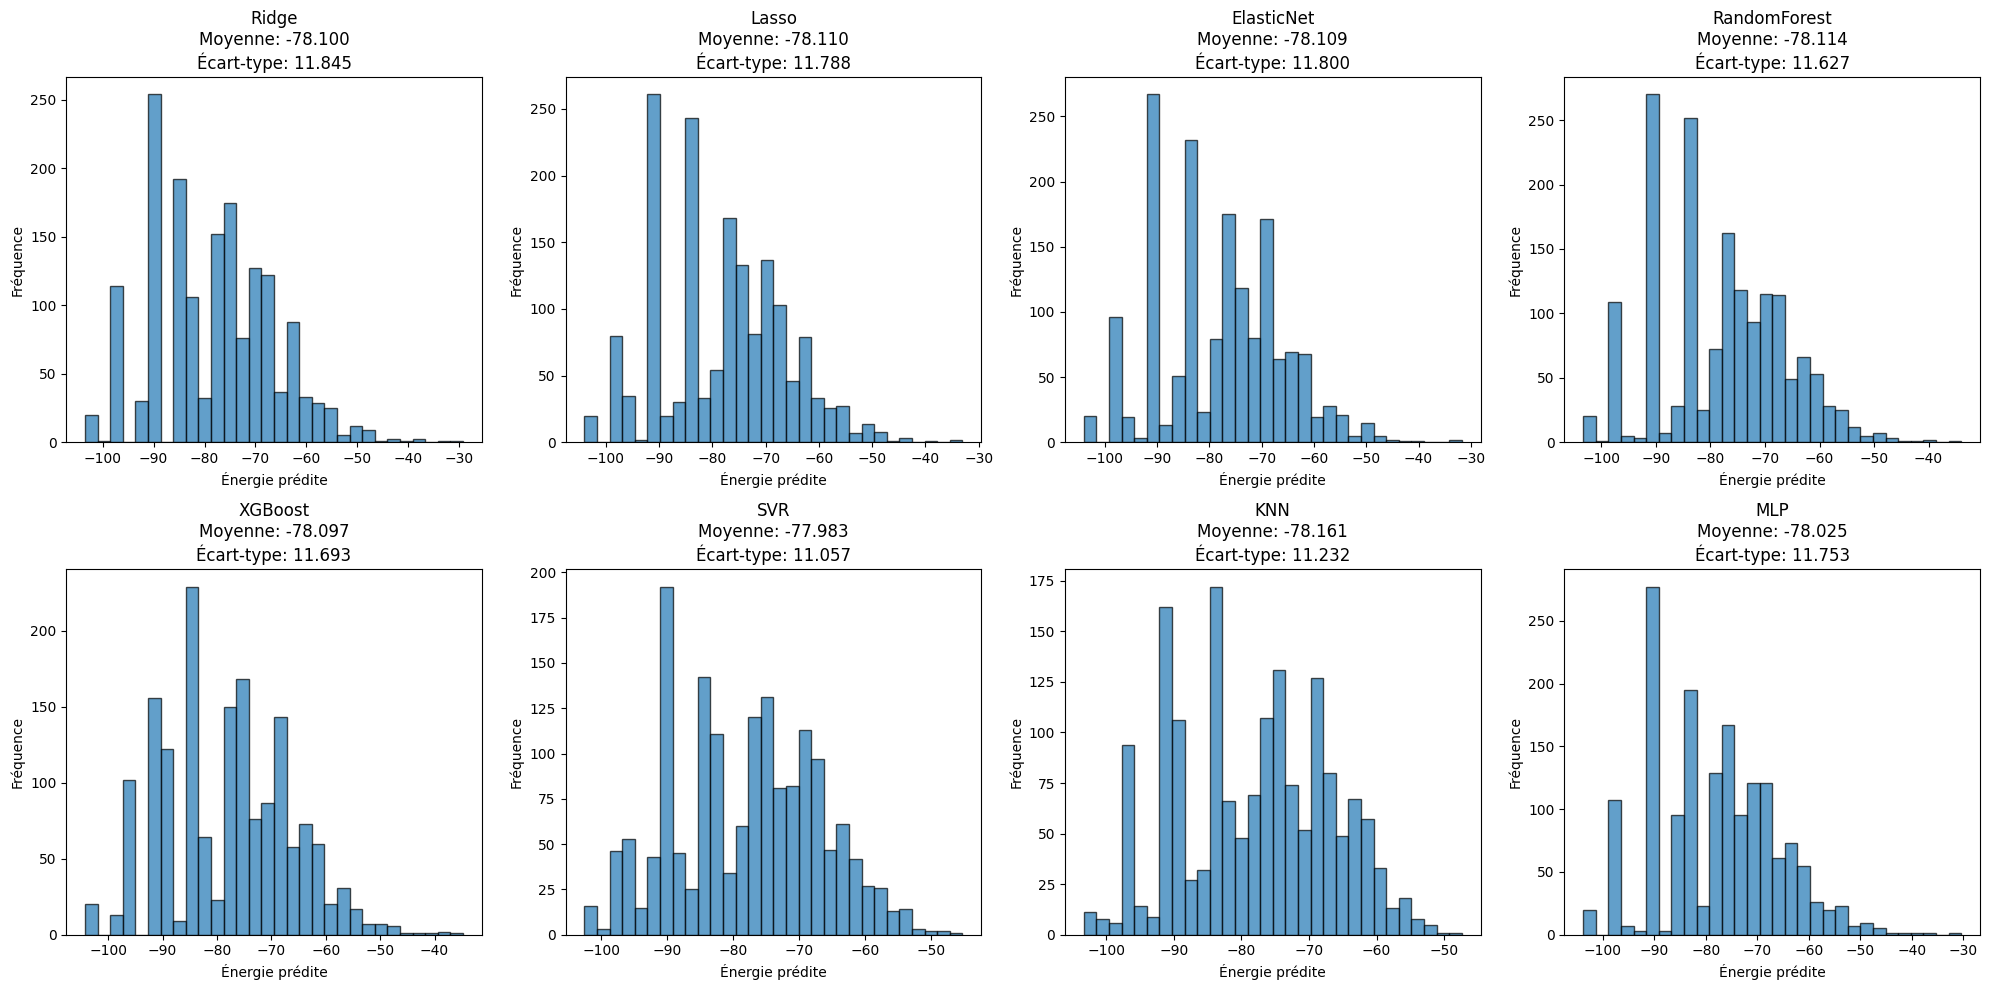

In [22]:
# Analyser la distribution des pr√©dictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (name, predictions) in enumerate(test_predictions.items()):
    ax = axes[i]
    ax.hist(predictions, bins=30, alpha=0.7, edgecolor='black')
    ax.set_title(f'{name}\nMoyenne: {predictions.mean():.3f}\n√âcart-type: {predictions.std():.3f}')
    ax.set_xlabel('√ânergie pr√©dite')
    ax.set_ylabel('Fr√©quence')

plt.tight_layout()
plt.show()

## R√©sum√© final

In [ ]:
print("\n" + "="*80)
print("R√âSUM√â FINAL")
print("="*80)

print(f"\nDescripteurs utilis√©s:")
print(f"  - Scattering 3D (ordres 0, 1, 2): {centered_orders_0.shape[1] + centered_orders_1_and_2.shape[1]} features")
print(f"  - Matrices de Coulomb: {train_coulomb_matrices.shape[1]} features")
print(f"  - SOAP: {soap_features.shape[1]} features")
print(f"  - ACSF: {acsf_features.shape[1]} features")
print(f"  - TOTAL: {all_features.shape[1]} features")

print(f"\nPerformances sur l'ensemble d'entra√Ænement:")
for i, (name, metrics) in enumerate(results_df.iterrows()):
    status = "üèÜ" if i == 0 else "  "
    print(f"  {status} {name:12s}: RMSE = {metrics['RMSE']:.4f}, MAE = {metrics['MAE']:.4f}")

print(f"\nFichiers de pr√©dictions g√©n√©r√©s:")
for name in trained_models.keys():
    print(f"  - test_pred_multi_descriptors_{name}.csv")

print(f"\nMeilleur mod√®le: {best_model_name}")
print("="*80)


R√âSUM√â FINAL

Descripteurs utilis√©s:
  - Scattering 3D (ordres 0, 1, 2): 120 features
  - Matrices de Coulomb: 23 features
  - SOAP: 11172 features
  - ACSF: 140 features
  - TOTAL: 11455 features

Performances sur l'ensemble d'entra√Ænement:
  üèÜ XGBoost     : RMSE = 0.0441, MAE = 0.0327
     Ridge       : RMSE = 0.0656, MAE = 0.0451
     ElasticNet  : RMSE = 0.3591, MAE = 0.2483
     RandomForest: RMSE = 0.4097, MAE = 0.1913
     Lasso       : RMSE = 0.4214, MAE = 0.2843
     SVR         : RMSE = 1.6338, MAE = 0.8501
     KNN         : RMSE = 1.8118, MAE = 0.7965
     MLP         : RMSE = 2.3237, MAE = 0.3932

Fichiers de pr√©dictions g√©n√©r√©s:
  - test_pred_multi_descriptors_Ridge.csv
  - test_pred_multi_descriptors_Lasso.csv
  - test_pred_multi_descriptors_ElasticNet.csv
  - test_pred_multi_descriptors_RandomForest.csv
  - test_pred_multi_descriptors_XGBoost.csv
  - test_pred_multi_descriptors_SVR.csv
  - test_pred_multi_descriptors_KNN.csv
  - test_pred_multi_descriptors_M